# Stackoverflow data

## Init

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import os
import re
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk.corpus import stopwords
from utils import monitor, examine_df
from sklearn.datasets.lfw import Bunch
from raw_preprocessor import RawPreprocessor
from html_preprocessor import HTMLPreprocessor

In [4]:
%matplotlib inline
sns.set_style('darkgrid')

In [5]:
args = Bunch()

## Read

In [6]:
args.data_kaggle_name = 'pythonquestions'

In [7]:
!pip install kaggle
!kaggle datasets download -d stackoverflow/$args.data_kaggle_name

pythonquestions.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
_base_path = f'~/.kaggle/datasets/stackoverflow/{args.data_kaggle_name}'
questions_path = os.path.join(_base_path, 'Questions.csv')
tags_path = os.path.join(_base_path, 'Tags.csv')

In [9]:
%time qdf = pd.read_csv(questions_path, encoding='ISO-8859-1')
examine_df(qdf)

CPU times: user 8.94 s, sys: 736 ms, total: 9.67 s
Wall time: 9.67 s
shape=(607282, 6)


name                    Id  OwnerUserId          CreationDate    Score  \
pos                      0            1                     2        3   
head 0                 469          147  2008-08-02T15:11:16Z       21   
     1                 502          147  2008-08-02T17:01:58Z       27   
     2                 535          154  2008-08-02T18:43:54Z       40   
     3                 594          116  2008-08-03T01:15:08Z       25   
     4                 683          199  2008-08-03T13:19:16Z       28   
tail 607277       40143190       333403  2016-10-19T23:36:01Z        1   
     607278       40143228  6.66246e+06  2016-10-19T23:40:00Z        0   
     607279       40143267  4.06468e+06  2016-10-19T23:44:07Z        0   
     607280       40143338  7.04498e+06  2016-10-19T23:52:27Z        2   
     607281       40143365  4.13313e+06  2016-10-19T23:55:49Z        0   
meta type            int64      float64                object    int64   
     has_null        False         True                 False    False   
math count          607282       601070                607282   607282   
     unique            NaN          NaN                606068      NaN   
     top               NaN          NaN  2016-08-29T11:28:51Z      NaN   
     freq              NaN          NaN                     3      NaN   
     mean      2.37196e+07  2.51959e+06                   NaN  2.28314   
     std       1.12472e+07  1.91038e+06                   NaN  19.2856   
     min               469           25                   NaN      -44   
     25%       1.48552e+07       853934                   NaN        0   
     50%        2.5319e+07  2.10768e+06                   NaN        1   
     75%       3.35882e+07  3.99116e+06                   NaN        2   
     max       4.01434e+07  7.04499e+06                   NaN     5524   

name                                                       Title  \
pos                                                            4   
head 0         How can I find the full path to a font from it...   
     1                   Get a preview JPEG of a PDF on Windows?   
     2         Continuous Integration System for a Python Cod...   
     3            cx_Oracle: How do I iterate over a result set?   
     4         Using 'in' to match an attribute of Python obj...   
tail 607277    How to execute multiline python code from a ba...   
     607278    How to get google reCaptcha image source using...   
     607279        Updating an ManyToMany field with Django rest   
     607280                                  Most possible pairs   
     607281              Theano operations returning odd results   
meta type                                                 object   
     has_null                                              False   
math count                                                607282   
     unique                                               606928   
     top                 TypeError: 'str' object is not callable   
     freq                                                      8   
     mean                                                    NaN   
     std                                                     NaN   
     min                                                     NaN   
     25%                                                     NaN   
     50%                                                     NaN   
     75%                                                     NaN   
     max                                                     NaN   

name                                                        Body  
pos                                                            5  
head 0         <p>I am using the Photoshop's javascript API t...  
     1         <p>I have a cross-platform (Python) applicatio...  
     2         <p>I'm starting work on a hobby project with a...  
     3         <p>There are several ways to iterate over a re...  
     4         <p>I don't remember whether I w

In [10]:
qdf.drop(['OwnerUserId', 'CreationDate', 'Score'], axis=1, inplace=True)
qdf.rename({c: c.lower() for c in qdf.columns}, axis=1, inplace=True)
examine_df(qdf, exclude='tail, math')

shape=(607282, 3)


name              id                                              title  \
pos                0                                                  1   
head 0           469  How can I find the full path to a font from it...   
     1           502            Get a preview JPEG of a PDF on Windows?   
     2           535  Continuous Integration System for a Python Cod...   
     3           594     cx_Oracle: How do I iterate over a result set?   
     4           683  Using 'in' to match an attribute of Python obj...   
meta type      int64                                             object   
     has_null  False                                              False   

name                                                        body  
pos                                                            2  
head 0         <p>I am using the Photoshop's javascript API t...  
     1         <p>I have a cross-platform (Python) applicatio...  
     2         <p>I'm starting work on a hobby project with a...  
     3         <p>There are several ways to iterate over a re...  
     4         <p>I don't remember whether I was dreaming or ...  
meta type                                                 object  
     has_null                                              False

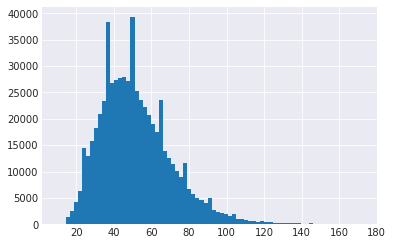

In [11]:
qdf.title.map(len).hist(bins=75);

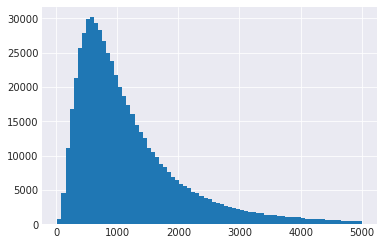

In [12]:
body_lens = qdf.body.map(len)
body_lens = body_lens[body_lens <= 5000]
body_lens.hist(bins=75);

## Text

In [13]:
args.log_step = 5000

In [14]:
sample = qdf.body.sample().iloc[0]
sample, HTMLPreprocessor().fit_transform([sample])[0]

("<p>I have a table in Excel and I want to be able to read it (I know how to achieve this) but also tell Python that if there are certain values of d, D and B, for it to return the dimension value in the top first row as a variable in my programme. I have read various posts concerning intersections and I am not sure whether they were what I was looking for therefore I have decided to ask my own question.</p>\n\n<p>My Excel table is in the format as follows (just a small example since I can't post images):</p>\n\n<pre><code>                      Dimensions\nd      D  |  17      27    37     47       17-47\n          |                B           |   rsmin\n0.6    2     0.8     -     -       -       0.05\n1    2.5     1       -     -       -       0.05\n1.5    3     1       -     1.8     -       0.05\n2      4     1.2     -     2       -       0.05\n</code></pre>\n\n<p>If I take an example and I have a d = 2, D = 4 (these two values will always be in the same row) and B = 2. I therefore w

In [15]:
preprocessor = HTMLPreprocessor(
    monitor=monitor('[1.6.1] Bodies filtering', log_step=args.log_step),
    do_tqdm=True
)
bodies = preprocessor.fit_transform(qdf.body)

100%|██████████| 607282/607282 [19:25<00:00, 521.10it/s]


In [16]:
%time texts = [f'{t}\n{b}' for t, b in zip(qdf.title, bodies)]
random.sample(texts, 3)

CPU times: user 312 ms, sys: 180 ms, total: 492 ms
Wall time: 490 ms


["Python OSError: [Errno 2] No such file err\nI'm trying to use python webdriver to get html source in linux.\nBut I got below error:\n CODE \nCan someone help me?\nversion: python -> 2.7.9\nThis is my code.\n CODE \n",
 "python and cdll in the ctypes. cannot use the printf\nI'm a beginner in learning Python. \nThe version of python I'm using is 3.2.1.1 \nI'm trying to learn the ctypes by following the tutorial from docs.python.org\nin the intereactive prompt, \n CODE \nit should return the value 42\nbut in my case, it returns 0.\nSo what's the problem? Thank very much.\n\nNow after I add a >>>from ctypes import cdll, the result became shows this\n CODE \n",
 "Install Python extension to specific location\nMy project mix pure Python code, and Cython extensions for optimization and for linking with C libraries. I have one source tree for my Python project, and one for Cython and C code. My Cython extensions each have a setup.py file to build them. Actually, for each extension, I do the 

## Tags

In [17]:
tdf = pd.read_csv(tags_path, encoding='latin1')
examine_df(tdf, exclude='math')

shape=(1885078, 2)


name                 Id        Tag
pos                   0          1
head 0              469     python
     1              469        osx
     2              469      fonts
     3              469  photoshop
     4              502     python
tail 1885073   40143338     python
     1885074   40143365     python
     1885075   40143365      numpy
     1885076   40143365     theano
     1885077   40143365       nnet
meta type         int64     object
     has_null     False       True

In [18]:
tdf.rename({c: c.lower() for c in tdf.columns}, axis=1, inplace=True)
tdf = tdf.dropna()
tdf.reset_index(drop=True, inplace=True)
examine_df(tdf, exclude='tail, math')

shape=(1884635, 2)


name              id        tag
pos                0          1
head 0           469     python
     1           469        osx
     2           469      fonts
     3           469  photoshop
     4           502     python
meta type      int64     object
     has_null  False      False

In [19]:
print(f'total={len(tdf.tag.unique())}')
tdf.tag.value_counts()[:20]

total=16895


python               607283
django                62818
python-2.7            34616
pandas                26854
python-3.x            26814
numpy                 25848
list                  18951
matplotlib            16521
regex                 14047
dictionary            13413
tkinter               10766
string                10616
flask                 10488
google-app-engine     10286
csv                    9323
arrays                 9170
json                   8023
mysql                  7529
linux                  7121
html                   7118
Name: tag, dtype: int64

In [20]:
@monitor('[1.6.2] Join tags', log_step=args.log_step, log_total=len(tdf))
def join_tags(*, log):
    tags = [[] for _ in range(len(qdf))]
    id2i = dict(zip(qdf.id, qdf.index))
    for i, (_, (id_, tag)) in enumerate(tqdm(tdf.iterrows(), total=len(tdf))):
        if id_ in id2i:
            tags[id2i[id_]].append(tag)
        log.istep(i)
    return tags

In [21]:
tags = join_tags()
random.sample(tags, 3)

100%|██████████| 1884635/1884635 [03:15<00:00, 9633.37it/s]


[['python', 'django', 'multi-tenant', 'mezzanine', 'django-sites'],
 ['python', 'single-sign-on', 'plone', 'zope'],
 ['python', 'seo', 'hyperlink']]

In [22]:
raw = [{'text': text, 'tags': i_tags} for text, i_tags in zip(texts, tags)]
random.sample(raw, 3)

[{'tags': ['python', 'python-2.7'],
  'text': "Splitting dict by value of one of the keys\nI've got a dictionary with data of the same length (but different types), something like:\n CODE \nNow I'd like to split it in two by  CODE , keeping the respective  CODE  and  CODE . That is, to have two dicts  CODE  and  CODE .\nNote: this is merely a sample, there are multiple keys in the dict and I would want to avoid using the key names, but rather loop through all of them.\nWhat is a Pythonic way of doing it?\n"},
 {'tags': ['python', 'snort'],
  'text': "Convert Snort string to Python timestamp\nI'm using Snort, which generates timestamps in MM-DD/time format, such as:\n CODE \nI want to convert this to a Python timestamp, including the current year. What's the most pythonic way?\n"},
 {'tags': ['python', 'python-2.7', 'dictionary', 'counter'],
  'text': 'How to keep my original dict when doing additon of Counter\nTo my understanding, I know when I invoke  CODE  to covert dict. This dict i

In [23]:
preprocessor = RawPreprocessor(
    monitor=monitor('[1.6.3] Stackoverflow preprocessing', log_step=args.log_step),
    do_tqdm=True
)
df = preprocessor.fit_transform(raw)
examine_df(df, exclude='math')

100%|██████████| 607282/607282 [1:23:01<00:00, 121.90it/s]


shape=(584137, 2)


name                                                        text  \
pos                                                            0   
head 0         How can I find the full path to a font from it...   
     1         Get a preview JPEG of a PDF on Windows? DCNL I...   
     2         Continuous Integration System for a Python Cod...   
     3         cx_Oracle: How do I iterate over a result set?...   
     4         Using 'in' to match an attribute of Python obj...   
tail 584132    How to execute multiline python code from a ba...   
     584133    How to get google reCaptcha image source using...   
     584134    Updating an ManyToMany field with Django rest ...   
     584135    Most possible pairs DCNL Given a list of value...   
     584136    Theano operations returning odd results DCNL S...   
meta type                                                 object   
     has_null                                              False   

name                                 tags  
pos                                     1  
head 0         fonts osx photoshop python  
     1           image pdf python windows  
     2                             python  
     3         database oracle python sql  
     4            arrays iteration python  
tail 584132         bash multiline python  
     584133                        python  
     584134                 django python  
     584135                        python  
     584136      nnet numpy python theano  
meta type                          object  
     has_null                       False

## Sanity check

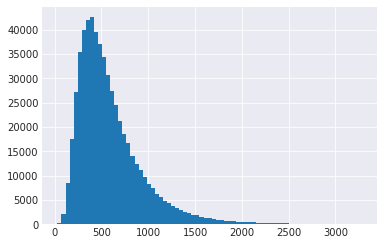

In [24]:
df.text.map(len).hist(bins=75);

In [25]:
df.text.sample(10).tolist()

["Any way to dict comprehension in dict comprehension in dict comprehension this? DCNL I have this piece of code: DCNL CODE DCNL ...where im is an image (numpy array), imdim its shape, shapes and contours are list of binary arrays of smaller dimensions (shapesize*shapesize) than im. DCNL It actually works, but I'm wondering if there is a way of writing all of this in a dict comprehension, inception-style. If yes, would it run faster ? DCNL Also, any comment on style or optimizations are welcome !",
 'How do I register tastypie resources from external app? DCNL I have a django based CMS system I am working on and it uses tastypie. While all resources native to the CMS are registered in a separate file imported later into urls.py some of the clients using the system require loading their own custom apps. Is there some way to register an additional resource without changing the main codebase?',
 'Python - How to redirect stderr to a file? DCNL The following code I got from http://forums.d

## Save

In [26]:
args.save_path = 'stackoverflow_data.hdf5'

In [27]:
%time df.to_hdf(args.save_path, 'df', mode='w', format='f', complevel=9)

CPU times: user 1.12 s, sys: 988 ms, total: 2.11 s
Wall time: 2.68 s


In [28]:
!du -sh $args.save_path

349M	stackoverflow_data.hdf5


## End

In [29]:
args

{'data_kaggle_name': 'pythonquestions',
 'log_step': 5000,
 'save_path': 'stackoverflow_data.hdf5'}